In [ ]:
!pip install datasets

In [ ]:
import os
import argparse
import datetime

import torch
import pandas as pd
from datasets import Dataset, logging as datasets_logging
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import gc
from model import Binoculars

torch.cuda.empty_cache(); gc.collect()

max_tokens = 128
# bino = Binoculars("Qwen/Qwen2.5-0.5B", "Qwen/Qwen2.5-0.5B-Instruct", max_token_length=128)
bino = Binoculars("tiiuae/falcon-7b", "tiiuae/falcon-7b-instruct", max_token_length=max_tokens)

# Load dataset
ds = Dataset.from_json("./cnn-llama2_13.jsonl")

for d in tqdm(ds):
    d["meta-llama-Llama-2-13b-hf_generated_text_wo_prompt"] = d["meta-llama-Llama-2-13b-hf_generated_text_wo_prompt"]
    d['article'] = d['article']

# Set keys
machine_sample_key = "meta-llama-Llama-2-13b-hf_generated_text_wo_prompt"
machine_text_source = "LLaMA-2-13B"


print(f"Scoring human text")

human_scores = []
batch = []
for i in tqdm(range(1000)):
    batch.append(ds[i]['article'])
    if len(batch) == 4:
        human_scores.extend(bino.forward(batch))
        batch = []
        torch.cuda.empty_cache(); gc.collect()


print(f"Scoring machine text")

machine_scores = []
batch = []
for i in tqdm(range(1000)):
    batch.append(ds[i][machine_sample_key])
    if len(batch) == 4:
        machine_scores.extend(bino.forward(batch))
        batch = []
        torch.cuda.empty_cache(); gc.collect()

score_df = pd.DataFrame(
    {"score": human_scores + machine_scores, "class": [0] * len(human_scores) + [1] * len(machine_scores)}
)
score_df["pred"] = np.where(score_df["score"] < 0.9015310749276843, 1, 0)

score_df.to_csv(f"score_df_{max_tokens}.csv")


f1_score = metrics.f1_score(score_df["class"], score_df["pred"])

print(f1_score)

100%|██████████| 2207/2207 [00:00<00:00, 15905.15it/s]


Scoring human text


100%|██████████| 1000/1000 [12:13<00:00,  1.36it/s]


Scoring machine text


100%|██████████| 1000/1000 [12:10<00:00,  1.37it/s]

0.6666666666666666 0.5672475 0.004


0.7525544202576633
0.8394024276377218
0.9140586189766517


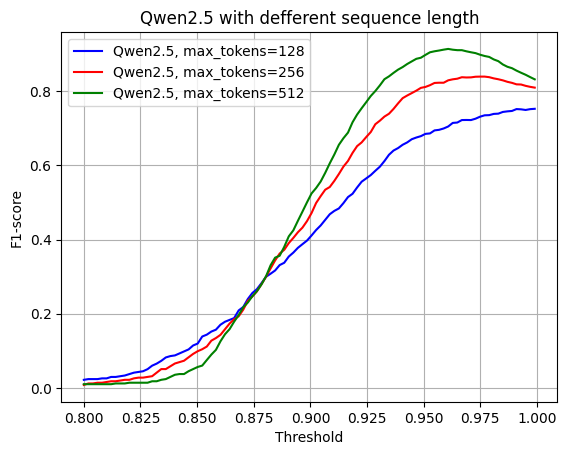

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

cl = {"score_df_256_q.csv": "r", "score_df_128_q.csv": "b", "score_df_512_q.csv": "green"}

for name in ["score_df_128_q.csv", "score_df_256_q.csv", "score_df_512_q.csv"]:
    score_df = pd.read_csv(name)
    f1s = []
    ts = []
    for threshold in np.linspace(0.8, 0.999, 100):
        score_df["pred"] = np.where(score_df["score"] < threshold, 1, 0)

        # Compute metrics
        f1_score = metrics.f1_score(score_df["class"], score_df["pred"])
        score = -1 * score_df["score"]  # We negative scale the scores to make the class 1 (machine) the positive class
        fpr, tpr, thresholds = metrics.roc_curve(y_true=score_df["class"], y_score=score, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        # Interpolate the TPR at FPR = 0.01%, this is a fixed point in roc curve
        tpr_at_fpr_0_01 = np.interp(0.01 / 100, fpr, tpr)

        ts.append(threshold)
        f1s.append(f1_score)
        # print(f1_score)
    plt.plot(np.array(ts), f1s, c=cl[name], label=f"Qwen2.5, max_tokens={name[-9:-6]}")
    print(max(f1s))
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Qwen2.5 with defferent sequence length")
plt.show()
# plt.scatter(int(file[-9:-6]),f1_score, c="r")
# print(f1_score, roc_auc, tpr_at_fpr_0_01)

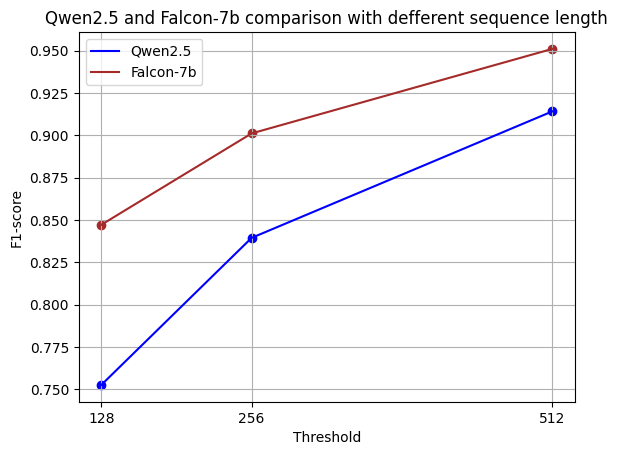

In [50]:
q_f1 = []
for name in ["score_df_128_q.csv", "score_df_256_q.csv", "score_df_512_q.csv"]:
    score_df = pd.read_csv(name)
    f1s = []
    ts = []
    for threshold in np.linspace(0.8, 0.999, 100):
        score_df["pred"] = np.where(score_df["score"] < threshold, 1, 0)

        # Compute metrics
        f1_score = metrics.f1_score(score_df["class"], score_df["pred"])
        score = -1 * score_df["score"]  # We negative scale the scores to make the class 1 (machine) the positive class
        fpr, tpr, thresholds = metrics.roc_curve(y_true=score_df["class"], y_score=score, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        # Interpolate the TPR at FPR = 0.01%, this is a fixed point in roc curve
        tpr_at_fpr_0_01 = np.interp(0.01 / 100, fpr, tpr)

        ts.append(threshold)
        f1s.append(f1_score)
    f1 = np.max(f1s)
    q_f1.append(f1)
    plt.scatter(int(name[-9:-6]), f1, c="blue")
plt.plot([128, 256, 512], q_f1, c="blue", label=f"Qwen2.5")

q_f1 = []
for name in ["score_df_128.csv", "score_df_256.csv", "score_df_512.csv"]:
    score_df = pd.read_csv(name)
    f1s = []
    ts = []
    for threshold in np.linspace(0.8, 0.999, 100):
        score_df["pred"] = np.where(score_df["score"] < threshold, 1, 0)

        # Compute metrics
        f1_score = metrics.f1_score(score_df["class"], score_df["pred"])
        score = -1 * score_df["score"]  # We negative scale the scores to make the class 1 (machine) the positive class
        fpr, tpr, thresholds = metrics.roc_curve(y_true=score_df["class"], y_score=score, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        # Interpolate the TPR at FPR = 0.01%, this is a fixed point in roc curve
        tpr_at_fpr_0_01 = np.interp(0.01 / 100, fpr, tpr)

        ts.append(threshold)
        f1s.append(f1_score)
    f1 = np.max(f1s)
    q_f1.append(f1)
    plt.scatter(int(name[-7:-4]), f1, c="brown")
plt.plot([128, 256, 512], q_f1, c="brown", label=f"Falcon-7b")

plt.legend()
plt.grid()
plt.xticks([128, 256, 512])
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Qwen2.5 and Falcon-7b comparison with defferent sequence length")
plt.show()